# CSCE 633 Machine Learning: Final Project
## By Rahaan Gandhi, 434007427

In [1]:
>>> import nltk
>>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Part A:

In [2]:
import pandas as pd
import nltk
import re

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/yelp_review_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/yelp_review_test.csv')

# Define a function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation using regular expression
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords using NLTK
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]

    # Join the words back into a string
    processed_text = ' '.join(words)

    return processed_text

# Apply text preprocessing to both training and testing data
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Convert star ratings into three levels
def convert_to_sentiment_category(stars):
    if stars > 3:
        return 'Positive'
    elif stars <= 2:
        return 'Negative'
    else:
        return 'Neutral'

train_data['sentiment'] = train_data['stars'].apply(convert_to_sentiment_category)
test_data['sentiment'] = test_data['stars'].apply(convert_to_sentiment_category)

# Save the preprocessed data to new CSV files
train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/yelp_review_train_preprocessed.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/yelp_review_test_preprocessed.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part B:

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine train and test data to build a unified vocabulary
all_data = pd.concat([train_data, test_data])

# Build the vocabulary using Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data['processed_text'])

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['processed_text'])

# Pad sequences to a fixed length
max_length = 150  # Choose an appropriate fixed length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Map sentiment categories to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_labels = train_data['sentiment'].map(sentiment_mapping)
test_labels = test_data['sentiment'].map(sentiment_mapping)

# Save the processed data and tokenizer
pd.DataFrame(train_padded).to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/train_padded.csv', index=False)
pd.DataFrame(test_padded).to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/test_padded.csv', index=False)
pd.DataFrame(train_labels).to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/train_labels.csv', index=False)
pd.DataFrame(test_labels).to_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/test_labels.csv', index=False)
tokenizer_json = tokenizer.to_json()
with open('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)


## Part C: Building Transformer model
## Part D: Training using SGD

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Load preprocessed data
train_padded = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/train_padded.csv').values
train_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/train_labels.csv').values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.1, random_state=42)

# Model parameters
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 32  # You can adjust this
num_heads = 8  # You can adjust this
ffn_units = 32  # You can adjust this
dropout_rate = 0.1

# Positional encoding
positional_encoding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embed_dim)(X_train)

# Transformer block
def transformer_block(inputs, embed_dim, num_heads, ffn_units, dropout=0.2):
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = tf.keras.layers.Add()([inputs, x])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ffn_units, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=1)(x)
    return tf.keras.layers.Add()([res, x])

# Build the model
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
positional_encoding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embed_dim)(inputs)

# Add positional encoding to the embedding
x = tf.keras.layers.Add()([embedding_layer, positional_encoding])

for _ in range(2):  # You can adjust the number of transformer blocks
    x = transformer_block(x, embed_dim, num_heads, ffn_units, dropout_rate)

# Apply GlobalAveragePooling1D along the sequence axis
x = GlobalAveragePooling1D()(x)

x = Dense(32, activation="relu")(x)  # You can adjust this
x = Dropout(0.1)(x)
outputs = Dense(3, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=optimizers.SGD(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training the model

history = model.fit(
    X_train, y_train,
    epochs=10,  # You can adjust this
    batch_size=32,  # You can adjust this
    validation_data=(X_val, y_val),
)

Epoch 1/10
4916/4916 [==============================] - 158s 31ms/step - loss: 0.8104 - accuracy: 0.6744 - val_loss: 0.8240 - val_accuracy: 0.6822
Epoch 2/10
4916/4916 [==============================] - 89s 18ms/step - loss: 0.6023 - accuracy: 0.7726 - val_loss: 0.5165 - val_accuracy: 0.8045
Epoch 3/10
4916/4916 [==============================] - 85s 17ms/step - loss: 0.4589 - accuracy: 0.8313 - val_loss: 0.4163 - val_accuracy: 0.8443
Epoch 4/10
4916/4916 [==============================] - 83s 17ms/step - loss: 0.4163 - accuracy: 0.8439 - val_loss: 0.4460 - val_accuracy: 0.8432
Epoch 5/10
4916/4916 [==============================] - 83s 17ms/step - loss: 0.3980 - accuracy: 0.8502 - val_loss: 0.3851 - val_accuracy: 0.8525
Epoch 6/10
4916/4916 [==============================] - 84s 17ms/step - loss: 0.3799 - accuracy: 0.8566 - val_loss: 0.3932 - val_accuracy: 0.8528
Epoch 7/10
4916/4916 [==============================] - 83s 17ms/step - loss: 0.3712 - accuracy: 0.8590 - val_loss: 0.3897 

## Part D: Graphs

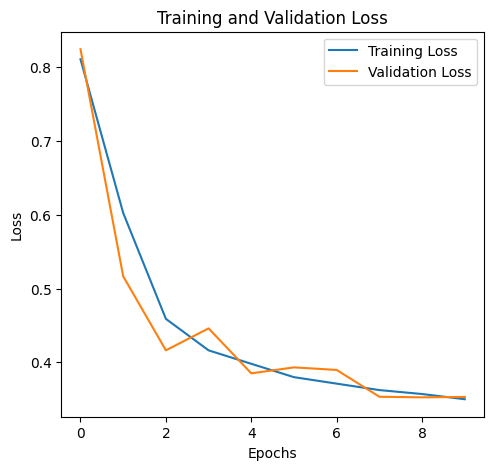

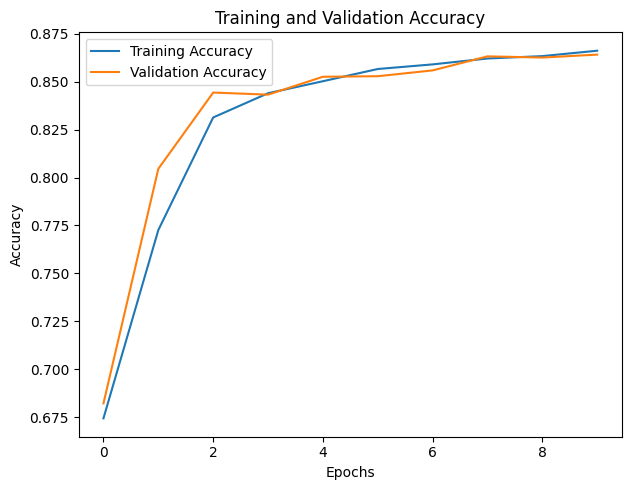

In [6]:
# Show data on graphs
# Epochs vs Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Epochs vs Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()

## Part E: Saving Model with best Test Accuracy

In [7]:
x_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/test_padded.csv').values
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/633 stuff/project/test_labels.csv').values
model.evaluate(x_test, y_test)

437/437 [==============================] - 3s 7ms/step - loss: 0.3556 - accuracy: 0.8632


[0.35561200976371765, 0.863233208656311]

In [ ]:
model.save("sgd_86.h5")

### Impacts of Hyper-parameter tuning:
1. Hidden Dimension:

 Hidden dimension represents the size of the models internal structure. A higher hidden dimension means a more complex internal structure of model, allowing it to learn more complex patterns while increasing demand for computing resources.

2. Number of Attention layers:

 With more attention layers the model can better detect dependencies or patterns in relationship between words in a sequence. This increases computation complexity and increases the draw on resources.

3. Number of Head in Multi-Attenttion layer:

 Multi-head attention allows model to simultaneously focus on different parts of the sequence, can allow for better learning representation.

4. Sequence Length:
 Sequence length is necessary to be tuned based on max or average length of sentences that will be turned to sequences for tokenization. Longer sequences require more memory and impacts performance while training and inference.

